<a href="https://colab.research.google.com/github/Hinakoushar-Tatakoti/Hand-written-Math-sysmbol-recognization/blob/master/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xainano/handwrittenmathsymbols

 98% 337M/343M [00:06<00:00, 55.5MB/s]
100% 343M/343M [00:06<00:00, 53.0MB/s]


In [ ]:
!unzip  handwrittenmathsymbols.zip

In [ ]:
!unrar x data.rar "/content/data/images/"

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

**Model Building**

In [ ]:

sdir=r'/content/data/images/extracted_images'
classlist=os.listdir(sdir)
print(classlist)
filepaths=[]
labels=[]
classes=[]
for klass in classlist:    
    classpath=os.path.join(sdir, klass)
    if os.path.isdir(classpath): 
        classes.append(klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(klass)


['lambda', 'pm', 'C', 'beta', '6', 'sin', '7', 'ldots', '8', 'int', 'q', 'e', 'M', 'o', 'X', 'N', '-', 'log', 'tan', 'prime', 'u', 'A', 'forall', 'in', 'y', 'ascii_124', '(', ',', 'exists', 'd', 'R', 'alpha', 'sum', 'div', 'i', 'sigma', '9', 'T', '5', '+', 'forward_slash', 'gamma', 'pi', '4', 'rightarrow', 'l', 'G', 'geq', '2', 'f', '!', 'lim', '=', 'mu', 'S', 'w', 'theta', 'p', ']', 'times', '{', 'H', 'leq', '0', 'phi', ')', 'Delta', 'k', 'j', '}', 'z', 'gt', 'lt', 'v', 'b', 'sqrt', 'infty', '1', '3', '[', 'cos', 'neq']


In [ ]:
fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series (labels, name='labels')
df=pd.concat([fseries, Lseries], axis=1)
balance=df['labels'].value_counts()
print (balance) # dataset is not reasonably balanced
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state = 123)
test_df, valid_df=train_test_split(df, train_size=dummy_split, shuffle=True, random_state=123)


-         33997
X         26594
1         26520
2         26141
+         25112
          ...  
Delta       137
lambda      109
in           47
forall       45
exists       21
Name: labels, Length: 82, dtype: int64


In [ ]:
def scalar(img):
    return img/127.5-1 # scale pixels between -1 and + 1


In [ ]:
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col='labels', target_size=(45,45), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)

test_gen=gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col='labels', target_size=(45,45), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)

valid_gen=gen.flow_from_dataframe(valid_df, x_col= 'filepaths', y_col='labels', target_size=(45,45), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)


Found 338376 validated image filenames belonging to 82 classes.
Found 187987 validated image filenames belonging to 82 classes.
Found 187987 validated image filenames belonging to 82 classes.


In [ ]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=(128,128,3), pooling='max', weights='imagenet') 
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x = Dropout(rate=.3, seed=123)(x)    

output=Dense(len(classes), activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)



In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])  


In [ ]:
estop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=4, verbose=1,restore_best_weights=True)


rlronp=tf.keras.callbacks.ReduceLROnPlateau(  monitor="val_loss",factor=0.2, patience=1, verbose=1)


history=model.fit(x=train_gen,  epochs=2, verbose=1, callbacks=[estop, rlronp],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


Epoch 1/2
10575/10575 [==============================] - 3556s 336ms/step - loss: 1.3670 - accuracy: 0.8779 - val_loss: 0.4964 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 2/2
10575/10575 [==============================] - 3578s 338ms/step - loss: 0.4440 - accuracy: 0.9427 - val_loss: 0.3683 - val_accuracy: 0.9516 - lr: 0.0010


In [ ]:
save_path=r'/content/mymodel.h5' # specify the path to where to save model
model.save(save_path)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:

history=model.fit(x=train_gen,  epochs=5, verbose=1, callbacks=[estop, rlronp],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


Epoch 1/5
10575/10575 [==============================] - 3539s 335ms/step - loss: 0.3406 - accuracy: 0.9553 - val_loss: 0.2968 - val_accuracy: 0.9591 - lr: 0.0010
Epoch 2/5
10575/10575 [==============================] - 3602s 341ms/step - loss: 0.2833 - accuracy: 0.9629 - val_loss: 0.2640 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 3/5
10575/10575 [==============================] - 3574s 338ms/step - loss: 0.2451 - accuracy: 0.9683 - val_loss: 0.2305 - val_accuracy: 0.9666 - lr: 0.0010
Epoch 4/5
10575/10575 [==============================] - 3554s 336ms/step - loss: 0.2196 - accuracy: 0.9717 - val_loss: 0.2141 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 5/5
10575/10575 [==============================] - 3641s 344ms/step - loss: 0.1987 - accuracy: 0.9746 - val_loss: 0.1974 - val_accuracy: 0.9720 - lr: 0.0010


# Model Evaluation

In [ ]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True);
# save the model to disk
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("model.model")
model.save_weights("weights_MobileV2.h5")

[INFO] serializing network...
INFO:tensorflow:Assets written to: model.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
val_loss, val_accuracy = model.evaluate(test_gen)
print(val_loss,val_accuracy)

5875/5875 [==============================] - 340s 58ms/step - loss: 0.1819 - accuracy: 0.9752
0.18187175691127777 0.975179135799408


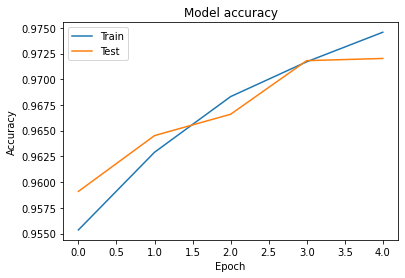

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuary_plot.png')
plt.show()

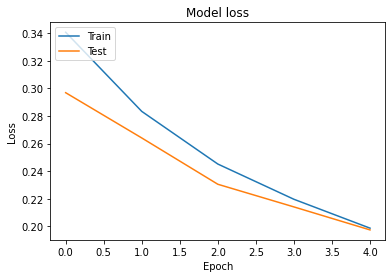

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss_plot.png')
plt.show()

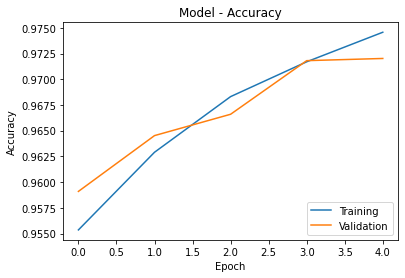

In [ ]:
# Train - Val plot
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig("train_val_plot.png")